In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from statsmodels.distributions.empirical_distribution import ECDF
import random
from random import seed
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import string
import scipy.stats as stats

In [2]:
#load csv
S = pd.read_csv("BTC-USD.csv")
S.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125,58119.578125,38702407772
1,2021-11-20,58115.082031,59859.878906,57469.726563,59697.195313,59697.195313,30624264863
2,2021-11-21,59730.507813,60004.425781,58618.929688,58730.476563,58730.476563,26123447605
3,2021-11-22,58706.847656,59266.359375,55679.839844,56289.289063,56289.289063,35036121783
4,2021-11-23,56304.554688,57875.515625,55632.761719,57569.074219,57569.074219,37485803899


<AxesSubplot:title={'center':'Daily Price of BTC in USD'}, xlabel='Date', ylabel='Bitcoin Price in USD'>

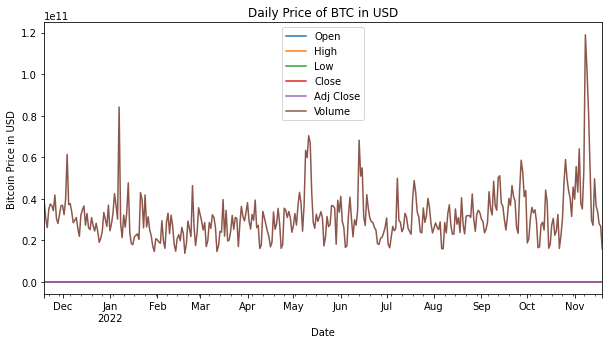

In [3]:
#raw data
series = pd.read_csv('BTC-USD.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot(title='Daily Price of BTC in USD', ylabel='Bitcoin Price in USD')

In [4]:
#cleaning data
S = S.drop(['High','Low','Close','Adj Close','Volume'], axis = 1)
#S = S[S['Open'] >= 1000]
S.head()

,Date,Open
0,2021-11-19,56896.128906
1,2021-11-20,58115.082031
2,2021-11-21,59730.507813
3,2021-11-22,58706.847656
4,2021-11-23,56304.554688


In [5]:
#data description
print(S["Open"].describe())
print(S["Open"].median())
print(S["Open"].mode())

count      366.000000
mean     32355.950374
std      11820.176548
min      15883.158203
25%      20594.497071
50%      30244.466797
75%      42198.630860
max      59730.507813
Name: Open, dtype: float64
30244.466797
0      15883.158203
1      16352.028320
2      16617.484375
3      16670.425781
4      16687.912109
           ...     
361    57830.113281
362    58115.082031
363    58706.847656
364    58960.285156
365    59730.507813
Length: 366, dtype: float64


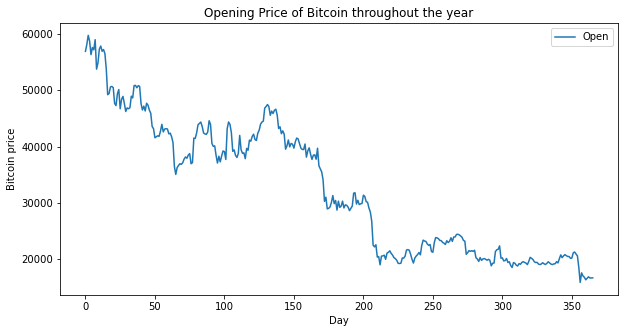

In [6]:
#plotting time series
S.plot(title= 'Opening Price of Bitcoin throughout the year',xlabel = 'Day', ylabel = 'Bitcoin price')
plt.show()

In [7]:
#assigning states
conditions = [
    (S['Open'] <= 20000),
    (S['Open'] > 20000) & (S['Open'] <= 30000),
    (S['Open'] > 30000) & (S['Open'] <= 40000),
    (S['Open'] > 40000) & (S['Open'] <= 50000),
    (S['Open'] > 50000)
    ]

values = [0,1,2,3,4]

S['States'] = np.select(conditions, values)
S.head()

,Date,Open,States
0,2021-11-19,56896.128906,4
1,2021-11-20,58115.082031,4
2,2021-11-21,59730.507813,4
3,2021-11-22,58706.847656,4
4,2021-11-23,56304.554688,4


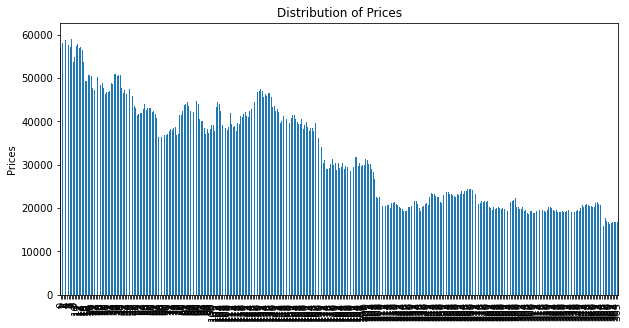

In [8]:
#plotting distribution of states
S['Open'].plot(kind ='bar',width = 0.6, title= 'Distribution of Prices', ylabel = 'Prices')

plt.show()

In [9]:
print(S["States"].describe())

count    366.000000
mean       1.726776
std        1.219339
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: States, dtype: float64


<AxesSubplot:title={'center':'Fraction of time spent in each State'}, xlabel='States'>

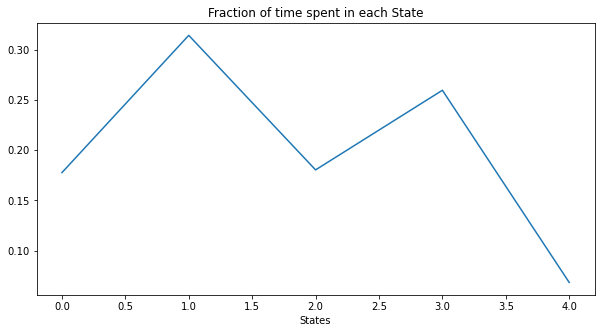

In [10]:
#Empirical Distribution
y = S['States'].value_counts(normalize=True)
z = y.sort_index(axis=0)
z.plot(title='Fraction of time spent in each State', xlabel='States')

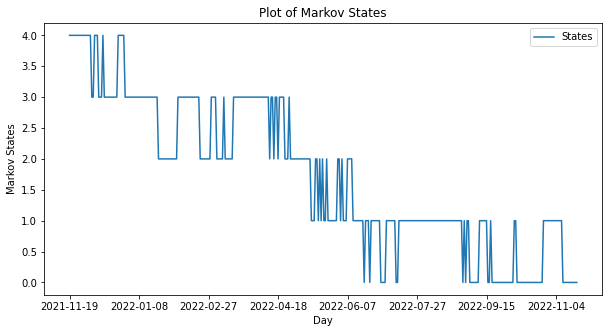

In [11]:
#Plot of States
S.plot(x="Date", y="States", title='Plot of Markov States', xlabel = 'Day', ylabel = 'Markov States')
plt.show()

In [12]:
#Transition Matrix
states = np.array(S['States'])
def TransitionMatrix(states):
    pd.value_counts(states)
    y = len(pd.unique(states))
    P = np.zeros([y,y])
    
    for i in range(y):
        for j in range(y):
            for x in range(len(states)-1):
                if states[x] == i and states[x+1] == j:
                    P[i][j] += 1

    for row in P:
        s = sum(row)
        if s > 0:
            row[:] = [round(f/s,3) for f in row]
    return P
P = TransitionMatrix(states)
P

array([[0.844, 0.156, 0.   , 0.   , 0.   ],
       [0.096, 0.843, 0.061, 0.   , 0.   ],
       [0.   , 0.121, 0.758, 0.121, 0.   ],
       [0.   , 0.   , 0.095, 0.874, 0.032],
       [0.   , 0.   , 0.   , 0.16 , 0.84 ]])

In [31]:
#Stationary Distribution
def StationaryDistribution(P):
    A = P.T-np.identity(P.shape[0])
    A = np.vstack([A,np.ones((P.shape[0]))])
    b = np.zeros((P.shape[0])).T
    b = np.zeros((P.shape[0]+1,1))
    b[-1] = 1
    W = np.linalg.lstsq(A,b,rcond=None)[0]
    return W
W = StationaryDistribution(P)
W

array([[0.21201313],
       [0.3449842 ],
       [0.17465264],
       [0.22385965],
       [0.04449037]])

<AxesSubplot:title={'center':'Plot of Stationary Distribution'}, xlabel='States'>

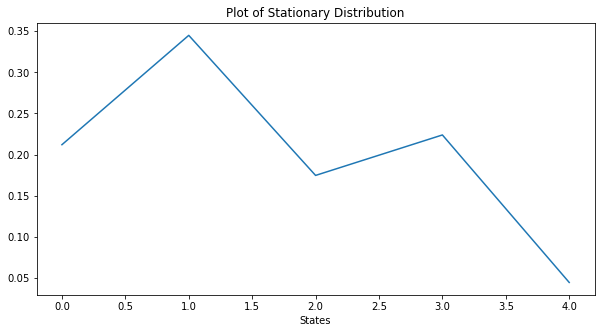

In [14]:
#Plot of stationary distribution
series = pd.Series(W.flatten()) 
series.plot(title='Plot of Stationary Distribution',xlabel='States')

In [15]:
#Markov chain simulation
P_dist = [np.cumsum(P[i, :]) for i in range(P.shape[0])]

def SimulateSeries(P,k):
    A = np.zeros(k, dtype=int)
    A[0] = random.choice(range(P.shape[0]))
    for t in range(k-1):
        x = round(random.uniform(0,1),2)
        arr = P_dist[A[t]]
        A[t+1] = min(i for i, e in enumerate(arr) if e >= x)
    return A
SimulateSeries(P,1000)

array([3, 4, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [16]:
P_dist

[array([0.844, 1.   , 1.   , 1.   , 1.   ]),
 array([0.096, 0.939, 1.   , 1.   , 1.   ]),
 array([0.   , 0.121, 0.879, 1.   , 1.   ]),
 array([0.   , 0.   , 0.095, 0.969, 1.001]),
 array([0.  , 0.  , 0.  , 0.16, 1.  ])]

In [17]:
A = np.zeros(1000, dtype=int)
A[0] = random.choice(range(P.shape[0]))
for t in range(999):
    x = round(random.uniform(0,0.95),2)
    print(x)
    arr = P_dist[A[t]]
    print(arr)
    A[t+1] = min([i for i, e in enumerate(arr) if e >= x])
    print([i for i, e in enumerate(arr) if e >= x])
    print(min([i for i, e in enumerate(arr) if e >= x]))

0.4
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.67
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.47
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.75
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.14
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.28
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.3
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.76
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.03
[0.096 0.939 1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.71
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.89
[0.844 1.    1.    1.    1.   ]
[1, 2, 3, 4]
1
0.54
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.22
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.79
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.09
[0.096 0.939 1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.92
[0.844 1.    1.    1.    1.   ]
[1, 2, 3, 4]
1
0.89
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.83
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.43
[0.096 0.939 1.    1.    1.   ]
[1, 2, 3, 4]
1
0.31


[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.72
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.78
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.71
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.28
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.16
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.23
[0.844 1.    1.    1.    1.   ]
[0, 1, 2, 3, 4]
0
0.9
[0.844 1.    1.    1.    1.   ]
[1, 2, 3, 4]
1
0.94
[0.096 0.939 1.    1.    1.   ]
[2, 3, 4]
2
0.43
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.61
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.26
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.21
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.31
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.59
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.91
[0.    0.121 0.879 1.    1.   ]
[3, 4]
3
0.84
[0.    0.    0.095 0.969 1.001]
[3, 4]
3
0.08
[0.    0.    0.095 0.969 1.001]
[2, 3, 4]
2
0.74
[0.    0.121 0.879 1.    1.   ]
[2, 3, 4]
2
0.02
[0.    0.121 0.879 1.    1.   ]

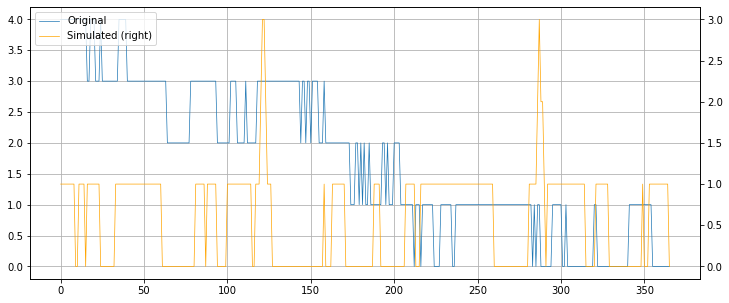

In [18]:
ts1 = pd.Series(states[0:366].flatten(),index=range(366))
ts2 = pd.Series(A[0:366].flatten(), index=range(366))

plt.figure(figsize=(12,5))

ax1 = ts1.plot(grid=True, label='Original', lw = 0.7)
ax2 = ts2.plot(color='Orange', grid=True, secondary_y=True, label='Simulated', lw = 0.7)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [19]:
#Autocorrelation Comparison
def Autocorrelation(X,k):
    X_b = np.average(X)
    n, d = 0, 0
    for i in range(0,len(X) - k):
        n += ((X[i] - X_b)*(X[i+k] - X_b))
    for i in range(0,len(X)):
        d += (X[i] - X_b)**2

    return n/d

In [20]:
states = np.array(S['States'])

In [21]:
ACF1, ACF2 = np.zeros(100), np.zeros(100)
for i in range(len(ACF1)):
    ACF1[i] = Autocorrelation(states,i)
    ACF2[i] = Autocorrelation(A,i)

In [22]:
df = pd.concat([ts1, ts2], axis=1)
df.corr(method='pearson')

,0,1
0,1.000000,0.001866
1,0.001866,1.000000


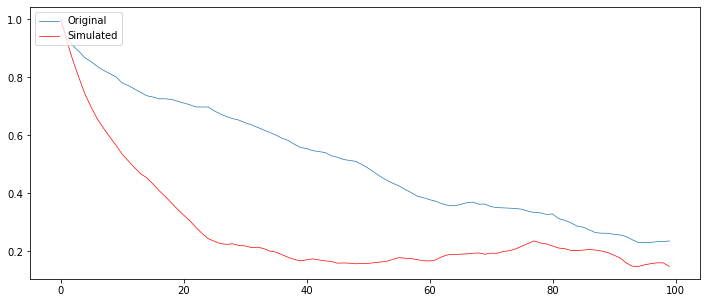

In [23]:
ts1 = pd.Series(ACF1.flatten(),index=range(100))
ts2 = pd.Series(ACF2.flatten(), index=range(100))

plt.figure(figsize=(12,5))

ax1 = ts1.plot(grid=True, label='Original', lw = 0.7)
ax2 = ts2.plot(color='Red', grid=False, secondary_y=False, label='Simulated', lw = 0.7)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1, l1, loc=2)
plt.show()

In [24]:
#Calculating two step Transition Frequencies
def TwoStepFrequency(states):
    pd.value_counts(states)
    y = len(pd.unique(states))
    P = np.zeros([y,y])
    
    for i in range(y):
        for j in range(y):
            for x in range(len(states)-2):
                if states[x] == i and states[x+2] == j:
                    P[i][j] += 1

    for row in P:
        s = sum(row)
        if s > 0:
            row[:] = [round(f/1,3) for f in row]
    return P
N = TwoStepFrequency(states)
N

array([[49., 14.,  0.,  0.,  0.],
       [16., 92.,  7.,  0.,  0.],
       [ 0.,  9., 46., 11.,  0.],
       [ 0.,  0., 13., 77.,  5.],
       [ 0.,  0.,  0.,  7., 18.]])

In [25]:
#Two step Transition Frequencies using Transition Matrix
Q = np.round(np.linalg.matrix_power(P, 2),3)
Q    

array([[0.727, 0.263, 0.01 , 0.   , 0.   ],
       [0.162, 0.733, 0.098, 0.007, 0.   ],
       [0.012, 0.194, 0.593, 0.197, 0.004],
       [0.   , 0.011, 0.155, 0.78 , 0.055],
       [0.   , 0.   , 0.015, 0.274, 0.711]])

In [26]:
n = np.zeros(N.shape[0])
for i in range(N.shape[0]):
    for j in range(N.shape[0]): 
        n[i] += N[i][j] 

In [32]:
#Goodness of Fit
def GoodnessofFit(N,Q):
    n = 0
    TS = np.zeros((N.shape[0]))
    chi2 = np.zeros(N.shape[0])
    p_value = np.zeros(N.shape[0])
    for i in range(N.shape[0]):
        N1 = N[i][Q[i]>0]
        n = N1.sum()
        chi2[i] = stats.chi2.ppf(q = 0.95, df = len(N1) - 1)
        for j in range(N.shape[0]):
            if Q[i][j] > 0:
                O = N[i][j]
                E = n * Q[i][j]
                TS[i] += ((O - E)**2 / E)
    return TS, chi2

In [33]:
GoodnessofFit(N,Q)

(array([1.25175601, 3.49838054, 3.69751162, 1.37026407, 0.38113277]),
 array([5.99146455, 7.8147279 , 9.48772904, 7.8147279 , 5.99146455]))